In [1]:
import json
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
from pycocotools.coco import COCO
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# LabelME To COCO

In [9]:
ann_path = './dataset/train/*.txt'
ann_files = glob(ann_path)

In [15]:
ann_files[0].split('\\')[-1]

'syn_00000.txt'

In [16]:
def labelmetxt2coco(anns):
    cars = {}
    # 숫자로 해도 되지만, 클래스 확인하기 위해 차종으로 변경
    classes = ["chevrolet_malibu_sedan_2012_2016", "chevrolet_malibu_sedan_2017_2019", "chevrolet_spark_hatchback_2016_2021", "chevrolet_trailblazer_suv_2021_", "chevrolet_trax_suv_2017_2019", "genesis_g80_sedan_2016_2020", "genesis_g80_sedan_2021_", "genesis_gv80_suv_2020_", "hyundai_avante_sedan_2011_2015", "hyundai_avante_sedan_2020_", "hyundai_grandeur_sedan_2011_2016", "hyundai_grandstarex_van_2018_2020", "hyundai_ioniq_hatchback_2016_2019", "hyundai_sonata_sedan_2004_2009", "hyundai_sonata_sedan_2010_2014", "hyundai_sonata_sedan_2019_2020", "kia_carnival_van_2015_2020", "kia_carnival_van_2021_", "kia_k5_sedan_2010_2015", "kia_k5_sedan_2020_", "kia_k7_sedan_2016_2020", "kia_mohave_suv_2020_", "kia_morning_hatchback_2004_2010", "kia_morning_hatchback_2011_2016", "kia_ray_hatchback_2012_2017", "kia_sorrento_suv_2015_2019", "kia_sorrento_suv_2020_", "kia_soul_suv_2014_2018", "kia_sportage_suv_2016_2020", "kia_stonic_suv_2017_2019", "renault_sm3_sedan_2015_2018", "renault_xm3_suv_2020_", "ssangyong_korando_suv_2019_2020", "ssangyong_tivoli_suv_2016_2020"]
    cars["categories"] = [{"id":i,"name":cat,"supercategory":"none"} for i, cat in enumerate(classes)]
    cars["images"] = []
    cars["annotations"] = []
    cnt_ann = 0
    for i, ann in enumerate(anns):
        img_path = ann.replace("txt", "png")
        img_name = img_path.split('\\')[-1]
        #h, w, _ = cv2.imread(img_path).shape
        cars["images"].append({"id":i,"height":1040,"width":1920,"file_name":img_name})

        f_ann = open(ann, "r")
        for line in f_ann.readlines():
            data = line.split()
            cat = int(float(data[0]))
            pt1x = int(data[1])
            pt1y = int(data[2])
            #pt2x = int(data[3])    not to use
            #pt2y = int(data[4])
            pt3x = int(data[5])
            pt3y = int(data[6])
            #pt4x = int(data[7])
            #pt4y = int(data[8])
            x = pt1x
            y = pt1y
            width = pt3x - pt1x
            height = pt3y - pt1y
            area = width * height
            cars["annotations"].append({"id": cnt_ann,
                                        "image_id": i,
                                        "category_id": cat,
                                        "bbox": [x, y, width, height],
                                        "area": area,
                                        "segmentation": [],
                                        "iscrowd": 0})
            cnt_ann += 1
        
    return cars

In [7]:
with open('./dataset/train.json','w') as f:
    json.dump(labelmetxt2coco(ann_files), f, ensure_ascii=False, indent = 4)

In [3]:
data_dir = './dataset'
train_load_path = None
inf_load_path = './checkpoints/faster_rcnn_scratch_checkpoints.pth'
annotation = os.path.join(data_dir,'train.json')

data_dir = data_dir
coco = COCO(annotation)
    
image_id = coco.getImgIds(imgIds=0)

image_info = coco.loadImgs(image_id)[0]

image = Image.open(image_info['file_name']).convert('RGB')
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

ann_ids = coco.getAnnIds(imgIds=image_info['id'])
anns = coco.loadAnns(ann_ids)





loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [8]:
image_info['file_name']

'./dataset/train\\syn_00000.png'

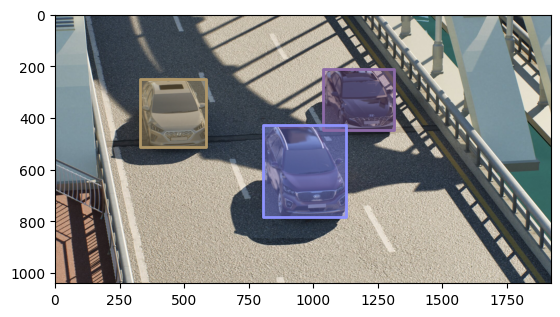

In [30]:
plt.imshow(image)
coco.showAnns(anns, draw_bbox = True)
plt.show()

# LabelME to YOLO

In [2]:
import glob
import os
import cv2
from tqdm import tqdm
import shutil
import math

In [3]:
txt_file_list = glob.glob('./dataset/train/*.txt')

In [11]:
file = txt_file_list[0]
file_name = os.path.basename(file)
file_name = file_name.split('.')[0]

In [14]:
img = cv2.imread('./dataset/train/' + file_name + '.png')


In [18]:
for file in tqdm(txt_file_list):
    file_name = os.path.basename(file)
    file_name = file_name.split('.')[0]
    img = cv2.imread('./dataset/train/' + file_name + '.png')
    img_height, img_width, _ = img.shape
#    print(file_name, img_height, img_width)
#    cv2.destroyAllWindows()
    with open(file, 'r') as f:
        lines_list = []
        lines = f.readlines()
        for line in lines:
            line = list(map(float, line.strip().split(' ')))
            class_name = int(line[0])
            x_min, y_min = float(min(line[5], line[7])), float(min(line[6], line[8]))
            x_max, y_max = float(max(line[1], line[3])), float(max(line[2], line[4]))
            x_center, y_center = float(((x_min + x_max) / 2) / img_width), float(((y_min + y_max) / 2) / img_height)
            width, height = abs(x_max - x_min) / img_width, abs(y_max - y_min) / img_height
            #print(x_center, y_center, width, height)
            lines_list.append([class_name, x_center, y_center, width, height])
    with open('./dataset/train/labels/' + file_name + '.txt', 'w') as f:
        for line in lines_list:
            f.write(str(line[0]) + ' ' + str(line[1]) + ' ' + str(line[2]) + ' ' + str(line[3]) + ' ' + str(line[4]) + '\n')

100%|██████████| 6481/6481 [04:12<00:00, 25.70it/s]
